In [23]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.optimizers import SGD

In [24]:
# Preparin our train, test and validation data along with labels

x_train=[]
y_train=[]
x_test=[]
y_test=[]
x_val=[]
y_val=[]

dim=128

path_train='../input/einterface-image-dataset/eINTERFACE_2021_Image/train'
path_test='../input/einterface-image-dataset/eINTERFACE_2021_Image/test'
path_val='../input/einterface-image-dataset/eINTERFACE_2021_Image/val'

category={'Anger':0,'Disgust':1,'Fear':2,'Happiness':3,'Sadness':4,'Surprise':5}

for i in sorted(os.listdir(path_train)):
#     print(i)
    path=os.path.join(path_train,i)
    for j in os.listdir(path):
        img=cv2.imread(os.path.join(path,j),0) #grayscaling
        img=cv2.resize(img,(dim,dim)) #resizing each image for uniformity
        x_train.append(img)
        y_train.append(category[i]) #adding labels for each image
        
print('Number of Training images:',len(x_train))
print('Number of Labels for training images:',len(y_train))

for i in sorted(os.listdir(path_test)):
#     print(i)
    path=os.path.join(path_test,i)
    for j in os.listdir(path):
        img=cv2.imread(os.path.join(path,j),0) #grayscaling
        img=cv2.resize(img,(dim,dim)) #resizing each image for uniformity
        x_test.append(img)
        y_test.append(category[i]) #adding labels for each image
        
print('Number of Testing images:',len(x_test))
print('Number of Labels for testing images:',len(y_test))

for i in sorted(os.listdir(path_val)):
    #print(i)
    path=os.path.join(path_val,i)
    for j in os.listdir(path):
        img=cv2.imread(os.path.join(path,j),0) #grayscaling
        img=cv2.resize(img,(dim,dim)) #resizing each image for uniformity
        x_val.append(img)
        y_val.append(category[i]) #adding labels for each image
        
print('Number of Validation images:',len(x_val))

print('Number of Labels for validation images:',len(y_val))

Number of Training images: 11475
Number of Labels for training images: 11475
Number of Testing images: 1438
Number of Labels for testing images: 1438
Number of Validation images: 1433
Number of Labels for validation images: 1433


In [25]:
# Converting lists into arrays, and normalising the image arrays.

x_train= np.array(x_train, dtype="float") / 255.0
x_test=np.array(x_test,dtype="float") / 255.0
x_val= np.array(x_val, dtype="float") / 255.0

y_train= np.array(y_train) 
y_test=np.array(y_test)
y_val=np.array(y_val)

y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test)
y_val=np_utils.to_categorical(y_val)

print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [26]:
# Reshaping our data for training

x_train_reshaped=x_train.reshape(x_train.shape[0],dim,dim,1)
x_test_reshaped=x_test.reshape(x_test.shape[0],dim,dim,1)
x_val_reshaped=x_val.reshape(x_val.shape[0],dim,dim,1)
print(x_train_reshaped.shape)
print(x_test_reshaped.shape)
print(x_val_reshaped.shape)

(11475, 128, 128, 1)
(1438, 128, 128, 1)
(1433, 128, 128, 1)


In [27]:
# We are using convo2D and fully connected dense layers for our classification.

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), input_shape=(dim,dim,1), activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(6,activation="softmax"))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)       

In [29]:
# Time based learning rate scheduling
epoch=5
learning_rate=0.01
decay_rate=learning_rate/epoch
momentum=0.8
sgd=SGD(lr=learning_rate,momentum=momentum,decay=decay_rate)

In [30]:
# Early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [31]:
# compiling the model 
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [32]:
#model.save_weights("my_initial_weights.h5")

In [33]:

model_history=model.fit(x_train_reshaped,y_train,batch_size=32,epochs=epoch,validation_data=(x_val_reshaped,y_val),shuffle=True, callbacks=[callback])

Epoch 1/5
359/359 [==============================] - 776s 2s/step - loss: 1.7083 - accuracy: 0.2603 - val_loss: 1.3215 - val_accuracy: 0.4606
Epoch 2/5
359/359 [==============================] - 767s 2s/step - loss: 1.2255 - accuracy: 0.4971 - val_loss: 1.0429 - val_accuracy: 0.6022
Epoch 3/5
359/359 [==============================] - 827s 2s/step - loss: 0.9329 - accuracy: 0.6360 - val_loss: 0.7926 - val_accuracy: 0.7132
Epoch 4/5
359/359 [==============================] - 764s 2s/step - loss: 0.7371 - accuracy: 0.7198 - val_loss: 0.6017 - val_accuracy: 0.8011
Epoch 5/5
359/359 [==============================] - 760s 2s/step - loss: 0.5698 - accuracy: 0.7826 - val_loss: 0.4998 - val_accuracy: 0.8353


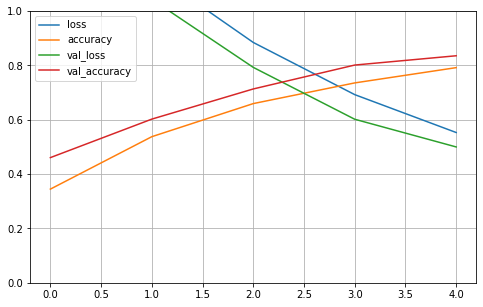

In [34]:
# plotting the varoius metrics
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [35]:
# Testing the model
model.evaluate(x_test_reshaped,y_test)

45/45 [==============================] - 17s 373ms/step - loss: 0.4862 - accuracy: 0.8526


[0.4861903786659241, 0.852573037147522]